<a href="https://colab.research.google.com/github/aalemi76/ENEL645/blob/main/ENENL645_Final_Project(MobileNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load Dataset**

In [23]:
import pandas
import numpy as np
import pandas as pd
import os
import keras
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input, ZeroPadding2D,Activation,MaxPooling2D,Add,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras import regularizers
from keras.utils import np_utils
from keras import callbacks
import tensorflow as tf
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
EPOCHS = 50 

In [24]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")

In [25]:
! pip install kaggle

In [26]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [27]:
! cp kaggle.json ~/.kaggle/

In [28]:
! chmod 600 ~/.kaggle/kaggle.json

In [29]:
! kaggle datasets download -d grassknoted/asl-alphabet

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
testfile = './asl_alphabet_test/asl_alphabet_test'
trainfile = './asl_alphabet_train/asl_alphabet_train'

In [34]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

### **Plot one picture to test the dataset**

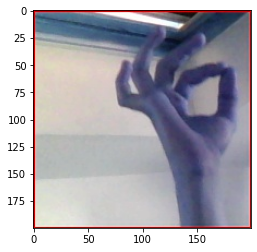


 (200, 200, 3)


In [35]:
ex = cv2.imread('./asl_alphabet_train/asl_alphabet_train/F/F1009.jpg')
plt.imshow(ex)
plt.show()
print('\n',ex.shape)

## **Image processing**

**Change RGB images to gray scale**

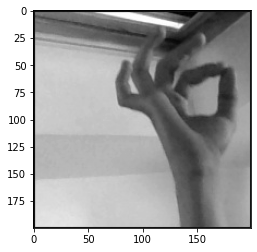

In [36]:
from skimage import color

ex1 = cv2.cvtColor(ex, cv2.COLOR_BGR2GRAY)
plt.imshow(ex1,cmap = 'gray')

### **Denoising**

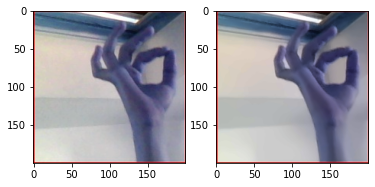

In [37]:
def denoise(image):
    
    denoised_image = cv2.fastNlMeansDenoisingColored(image,None,h=2)
    
    return denoised_image

denoise_ex = denoise(ex)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex)
plt.subplot(1,2,2)
plt.imshow(denoise_ex)

**Visualization**

dataset includes images of 3d ndarray and the shape of (200, 200) with a color image as the size 3

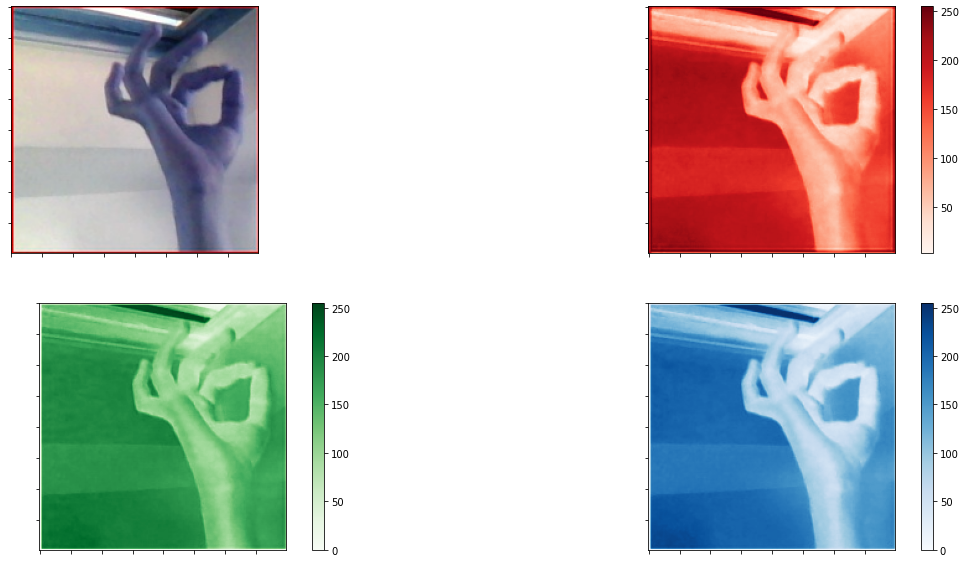

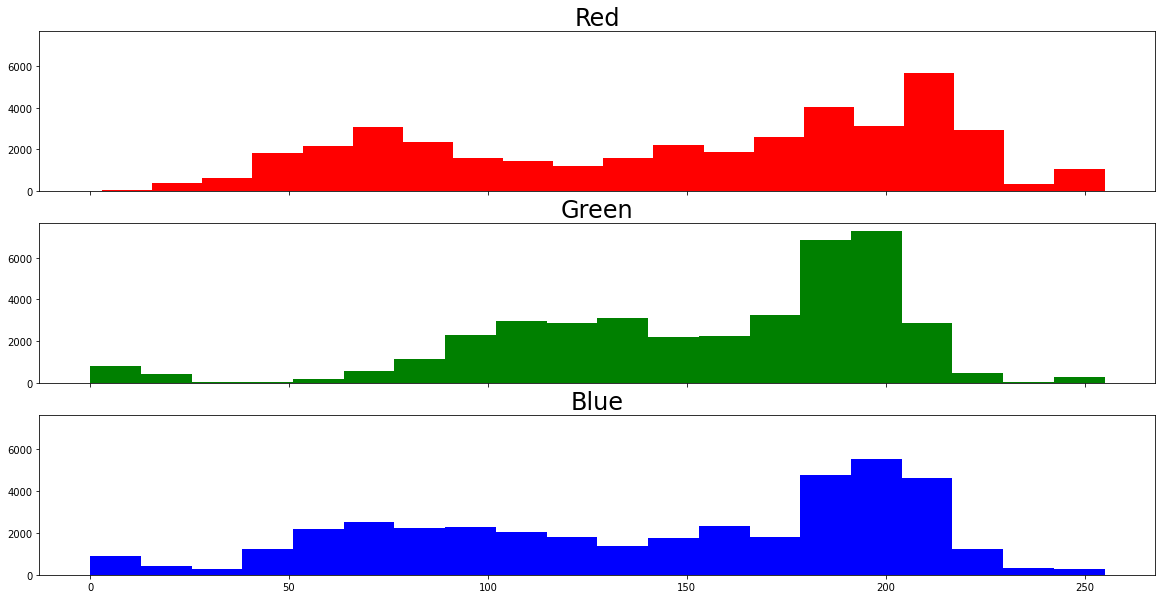

In [38]:
# color of the image
red = ex[:, :, 0]
blue= ex[:, :, 1]
green = ex[:,:,2]


#set up the figure for plotting
fig, axs = plt.subplots(2,2, figsize=(20, 10))

cax_00 = axs[0,0].imshow(ex)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

#plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20, 10))

axs[0].hist(red.ravel(), bins=20, color = 'red')
axs[0].set_title('Red',fontsize=24)
axs[1].hist(green.ravel(), bins=20, color = 'green')
axs[1].set_title('Green',fontsize=24)
axs[2].hist(blue.ravel(), bins=20, color = 'blue')
axs[2].set_title('Blue',fontsize=24)

plt.show()


*   Preprocess images(resize,denoise,enhance contrast)
*   Defining a dictionary which contains labels and its mapping to a number which acts as class label.
*   loading image data and labels and then mapping those labels to the dictionary defined before.
*   Normalizing image data.
*   converting labels to one hot format as our keras model don't accept categorical label.
*   Normalizing image data.
*   creating training and test data by splitting original data into 95% of training data and 5% testing data.







In [39]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'del':27,'nothing':28}

def load_data():

    """
    Loads sign language dataset.
    """
    
    #size = 60,60
    images, labels = [], []

    for folder in os.listdir(trainfile):
        
        print(folder, end = ' | ')
        for image in os.listdir(trainfile + "/" + folder):
            temp_img = cv2.imread(trainfile + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, (32,32))
            #temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
            images.append(temp_img)
            labels.append(labels_dict[folder])

            
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.05, random_state=42)
    
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [40]:
X_train, X_test, y_train, y_test = load_data()

y_train_ = keras.utils.np_utils.to_categorical(y_train,29)
y_test_ = keras.utils.np_utils.to_categorical(y_test,29)

I | U | V | B | T | Z | M | G | nothing | A | space | N | C | E | O | del | L | X | W | S | F | P | R | D | J | H | Y | K | Q | 
Loaded 82650 images for training, Train data shape = (82650, 32, 32, 3)
Loaded 4350 images for testing Test data shape = (4350, 32, 32, 3)


In [41]:
print("X_train shape  -> ", X_train.shape)
print("X_test shape   -> ", X_test.shape)
print("y_train_ shape -> ", y_train_.shape)
print("y_test_ shape  -> ", y_test_.shape)
print("len y_train    -> ", len(y_train))

X_train shape  ->  (82650, 32, 32, 3)
X_test shape   ->  (4350, 32, 32, 3)
y_train_ shape ->  (82650, 29)
y_test_ shape  ->  (4350, 29)
len y_train    ->  82650


In [55]:
from tensorflow.keras.applications import MobileNet
model=Sequential()
model.add(MobileNet(weights='imagenet', include_top=False, input_shape=(32,32,3)))
model.add(Flatten())
model.add(Dense(512,activation='sigmoid'))
model.add(Dense(29,activation='softmax'))

17235968/17225924 [==============================] - 0s 0us/step


In [58]:
def fit_model(model,epochs):
    
    earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, # minimium amount of change to count as an improvement
    patience=23, # how many epochs to wait before stopping
    restore_best_weights = True)
    
    model_hist = model.fit(X_train, y_train_, batch_size = 50, epochs = epochs, validation_split = 0.1, callbacks =[earlystopping])
    
    return model_hist

In [59]:
print('Train and Baseline Model with adam Optimizer and',5,' epochs') 
history = fit_model(model,5)

Train and Baseline Model with adam Optimizer and 5  epochs
Epoch 1/5
1488/1488 [==============================] - 57s 29ms/step - loss: 0.4136 - accuracy: 0.8740 - val_loss: 0.3294 - val_accuracy: 0.9087
Epoch 2/5
1488/1488 [==============================] - 44s 29ms/step - loss: 0.1329 - accuracy: 0.9612 - val_loss: 0.0906 - val_accuracy: 0.9725
Epoch 3/5
1488/1488 [==============================] - 41s 28ms/step - loss: 0.0961 - accuracy: 0.9732 - val_loss: 0.0903 - val_accuracy: 0.9769
Epoch 4/5
1488/1488 [==============================] - 42s 28ms/step - loss: 0.0760 - accuracy: 0.9793 - val_loss: 0.0357 - val_accuracy: 0.9908
Epoch 5/5
1488/1488 [==============================] - 42s 28ms/step - loss: 0.0630 - accuracy: 0.9831 - val_loss: 0.0222 - val_accuracy: 0.9948


### **Calculate model performance**

In [60]:
print('Training accuracy:', np.mean(history.history['accuracy']))
print('Training loss:', np.mean(history.history['loss']))
print('Validation accuracy:', np.mean(history.history['val_accuracy']))
print('Validation loss:', np.mean(history.history['val_loss']))

Training accuracy: 0.9541762471199036
Training loss: 0.15631361901760102
Validation accuracy: 0.9687356352806091
Validation loss: 0.11361962892115116


### **Plot model performance metrics**

In [61]:
def plot_performance(hist_model):
    
    plt.plot(hist_model.history['accuracy'])
    plt.plot(hist_model.history['val_accuracy'])
    plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
    plt.title('accuracy plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()
    
    plt.plot(hist_model.history['loss'])
    plt.plot(hist_model.history['val_loss'])
    plt.legend(['training loss', 'validation loss'], loc = 'upper right')
    plt.title('loss plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

 Model with preprocesisng with adam Optimizer and 50  epochs


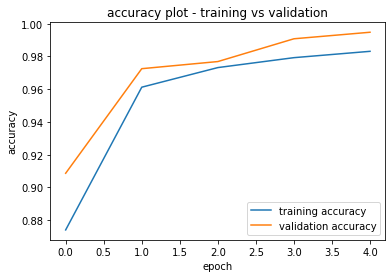

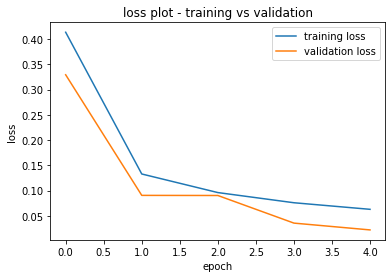

In [62]:
print(' Model with preprocesisng with adam Optimizer and',EPOCHS,' epochs') 
plot_performance(history)

### **Evaluate model on testing dataset**

In [63]:
def evaluate_model(model):
    test_loss,test_acc = model.evaluate(X_test, y_test_)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    
evaluate_model(model)

136/136 [==============================] - 2s 12ms/step - loss: 0.0322 - accuracy: 0.9926
Test accuracy: 0.9926436543464661
Test loss: 0.03216038644313812


In [64]:
from sklearn.metrics import classification_report

uniq_labels = sorted(os.listdir(trainfile))

y_pred = np.argmax(model.predict(X_test),1)
print(classification_report(y_test,y_pred))

print("Precision : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))
print("Recall    : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))
print("F1 Score  : {:.2f} %".format(precision_score(y_pred,y_test,average='macro')))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       168
           1       0.99      1.00      0.99       133
           2       1.00      1.00      1.00       144
           3       1.00      1.00      1.00       150
           4       0.99      0.99      0.99       139
           5       1.00      1.00      1.00       141
           6       1.00      1.00      1.00       141
           7       0.95      0.98      0.97       127
           8       1.00      0.99      1.00       156
           9       1.00      1.00      1.00       148
          10       0.99      1.00      1.00       128
          11       0.99      1.00      1.00       139
          12       1.00      0.99      1.00       141
          13       0.98      1.00      0.99       159
          14       1.00      0.97      0.99       153
          15       1.00      0.94      0.97       162
          16       0.98      1.00      0.99       138
          17       0.98    